# Problem statement, Data dictionary

Each sample is composed of data from 25 cells, covering an area of 625 m2. Each cell represents an area of 5 x 5 m2 and has nine features (as introduced in section 2). For a landslide sample, cell 13 is the location of landslide, and other cells are the neighboring areas. For a non-landslide sample, there is no recorded landslide occurrence within the sample area.

- CELLID_elevation	Continuous	
Digital elevation of the terrain surface in meter

- CELLID_slope	Continuous	
Angle of the slope inclination in degree

- CELLID_aspect	Continuous	
Exposition of the slope in degree
(direction of the slope?) -> dummied to 8 NSEW

- CELLID_placurv	Continuous	
Planform curvature, curvature perpendicular to the direction of the maximum slope

- CELLID_procurv	Continuous	
Profile curvature, curvature parallel to the slope, indicating the direction of maximum slope

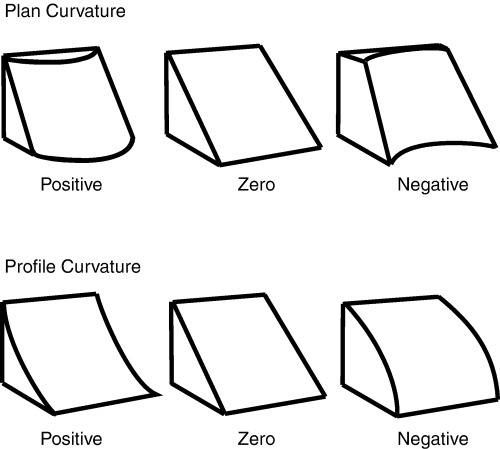


- CELLID_lsfactor	Continuous	
Length-slope factor that accounts for the effects of topography on erosion

- CELLID_twi	Continuous	
Topographic wetness index, an index to quantify the topographic control on hydrological process

- CELLID_geology	Categorical	Lithology of the surface material
1: Weathered Cretaceous granitic rocks
2: Weathered Jurassic granite rocks
3: Weathered Jurassic tuff and lava
4: Weathered Cretaceous tuff and lava
5: Quaternary deposits
6: Fill
7: Weathered Jurassic sandstone, siltstone and mudstone

- CELLID_sdoif	Continuous	
Step duration orographic intensification factor: an index to quantify the amplification of orography on rainfall


# 0. Import

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# all columns, limit 200 rows
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", 200)

# round up DISPLAY 4 decimal
pd.options.display.float_format = "{:,.4f}".format

import time

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.feature_selection import RFE



from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# !conda install -c conda-forge py-xgboost 
# !pip install xgboost
import xgboost as xgb

from sklearn.metrics import ( 
    f1_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    plot_confusion_matrix, 
    classification_report, 
    precision_recall_curve,
    make_scorer,
 
) 

# 1. Data preprocessing

Since adaboost is less proned to overfitting and curse of dimensionality, we'll try different combination of original data and engineered data

In [5]:
# original data
df_og = pd.read_csv('Train.csv').drop(columns=['Sample_ID', 'Label'])
df_og.head()

,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif
0,130,129,127,126,123,126,125,124,122,119,122,121,119,117,115,119,117,115,114,112,116,114,113,111,110,35.2644,37.2921,33.8545,35.7958,40.3155,38.8767,39.5097,40.5106,45.8345,45.0000,36.0550,40.5106,44.5637,41.8103,38.8767,33.8545,38.8767,33.8545,33.8545,32.6319,32.6319,30.2463,30.2463,30.2463,30.2463,98.1301,113.1986,116.5650,123.6901,135.0000,97.1250,104.0362,110.5560,119.0546,126.8699,105.9454,110.5560,113.9625,116.5650,119.7449,116.5650,119.7449,116.5650,116.5650,128.6598,128.6598,120.9638,120.9638,120.9638,120.9638,0.0385,0.0295,0.0314,0.0258,0.0105,0.0283,0.0274,0.0198,0.0093,0.0088,0.0215,0.0212,0.0173,0.0067,-0.0087,0.0239,0.0126,-0.0042,0.0036,-0.0068,0.0133,0.0053,0.0070,-0.0178,-0.0078,0.0139,0.0147,0.0182,0.0184,0.0033,0.0020,0.0057,0.0022,-0.0038,-0.0033,-0.0021,0.0036,0.0020,-0.0123,-0.0272,0.0010,-0.0126,-0.0316,-0.0257,-0.0374,-0.0189,-0.0219,-0.0236,-0.0485,-0.0391,8.0452,8.3330,7.8194,8.0322,9.8189,9.2958,9.3751,9.4994,10.9229,11.0019,9.3399,9.8832,11.0358,10.2980,9.6189,8.7032,10.1758,8.6511,8.2511,8.0745,8.5199,7.9892,7.6343,7.8042,7.2192,3.1733,2.9614,3.3159,3.0612,3.2469,3.2217,3.1535,3.0486,2.9155,3.0740,3.7653,3.2467,3.1545,3.2378,3.3925,3.8513,3.6739,3.8213,3.5846,3.7346,4.0031,4.2181,3.9909,4.1009,3.7152,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1.2818,1.2817,1.2817,1.2817,1.2816,1.2818,1.2818,1.2817,1.2817,1.2817,1.2818,1.2818,1.2817,1.2817,1.2817,1.2818,1.2818,1.2817,1.2817,1.2817,1.2818,1.2818,1.2818,1.2817,1.2817
1,161,158,155,153,151,162,159,155,153,151,162,159,156,153,151,162,160,157,153,151,162,160,157,154,150,32.3115,32.3115,26.5650,21.8014,22.4069,27.0171,35.2644,31.3112,21.8014,21.8014,30.9638,31.3112,32.3115,26.5650,21.8014,26.5650,27.0171,35.2644,31.3112,27.0171,26.5650,26.5650,30.

In [6]:
# engineered data
df = pd.read_csv('landslide_engineered_features.csv')
df.head()

,Label,aspect_NSEW,elevation_center,elevation_minmax_difference,slope_center,slope_difference_pct,aspect_span,aspect_sum_span_9cells,placurv_center_below_diff,placurv_signs_8,placurv_top_vs_2bottom,procurv_signs_8,procurv_top_vs_2bottom,lsfactor_sum_center_1below,twi_center,twi_25mean,geology_center,geology_9mode,sdoif_center
0,0,SE,119,20,44.5637,34.9797,37.8750,35.4213,0.0136,++-,0.0214,+--,0.0668,19.2870,3.1545,3.4665,3,3,1.2817
1,1,S,156,12,32.3115,41.6662,29.7449,91.5230,-0.0026,+++,-0.0193,---,0.0055,16.6390,4.3839,4.6605,3,3,1.3596
2,0,W,164,22,45.0000,77.7087,62.4027,106.3306,0.0048,+++,-0.0274,+++,0.0026,28.8700,4.1693,4.2278,2,2,1.3651
3,0,S,77,8,16.6992,86.5494,78.6901,45.0000,0.0089,+++,-0.0229,+-+,0.0146,8.2114,4.2599,3.7378,2,2,1.1008
4,0,SE,109,15,29.4962,32.6895,18.4350,72.4050,-0.0006,---,0.0181,---,0.0205,15.8179,4.4302,4.5421,2,5,1.2842


In [7]:
# Dummy
to_dummies = ['aspect_NSEW']
aspect_NSEW_dummies = pd.get_dummies(df[to_dummies], drop_first=True)
aspect_NSEW_dummies.columns = [x.replace('_NSEW','') for x in aspect_NSEW_dummies.columns]
df = pd.concat([df, aspect_NSEW_dummies], axis=1)

df.drop(columns='aspect_NSEW', inplace=True)

In [8]:
# convert to woe
from custom_functions import WOE

temp = pd.read_csv('df\Train.csv')
placurv_cols = temp.columns[1+25*3:26+25*3].tolist()
procurv_cols = temp.columns[1+25*4:26+25*4].tolist()

df = pd.concat([df, temp[placurv_cols]], axis=1)
df.placurv_signs_8 = df.placurv_signs_8.map(WOE.convert_woe_cat('placurv_signs_8', df)['WOE'])

df = pd.concat([df, temp[procurv_cols]], axis=1)
df.procurv_signs_8 = df.procurv_signs_8.map(WOE.convert_woe_cat('procurv_signs_8', df)['WOE'])

df.drop(columns=placurv_cols+procurv_cols, inplace=True)

Information value: 0.13
Information value: 0.11


In [9]:
df_combined = pd.concat([df_og, df], axis=1)

**Class weights**

In [10]:
df.Label.value_counts(normalize=True)

0   0.7500
1   0.2500
Name: Label, dtype: float64

In [11]:
class_weights = {0: .25, 1: .75}

# 2. ADA

## Custom functions

In [12]:
from custom_functions import classification_functions as clf

In [30]:
def tree_model_perf(model, model_name, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_test  = model.predict(X_test)
    yhat_proba = model.predict_proba(X_test)[::,1]
    auc_score = metrics.roc_auc_score( y_test, yhat_proba )
    
    time_complete = time.time() - start
    
    print(f'{model_name}:  AUC = {auc_score:.3f}, Time: {time_complete:.2f}')
    print('Train')
    print(classification_report(y_train, yhat_train))
    print('Test')
    print(classification_report(y_test, yhat_test))
    
    
    
    clf.cf_train_test(y_train, yhat_train, y_test, yhat_test)
    print('*'*90)

## Engineered data

In [31]:
X_eng = df.drop(columns='Label')
Y = df.Label

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, Y, stratify=Y, test_size=0.1, random_state=14)

ADA_base:  AUC = 0.865, Time: 0.75
Train
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      7333
           1       0.69      0.59      0.64      2444

    accuracy                           0.83      9777
   macro avg       0.78      0.75      0.76      9777
weighted avg       0.83      0.83      0.83      9777

Test
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       815
           1       0.68      0.55      0.61       272

    accuracy                           0.82      1087
   macro avg       0.77      0.73      0.75      1087
weighted avg       0.81      0.82      0.82      1087



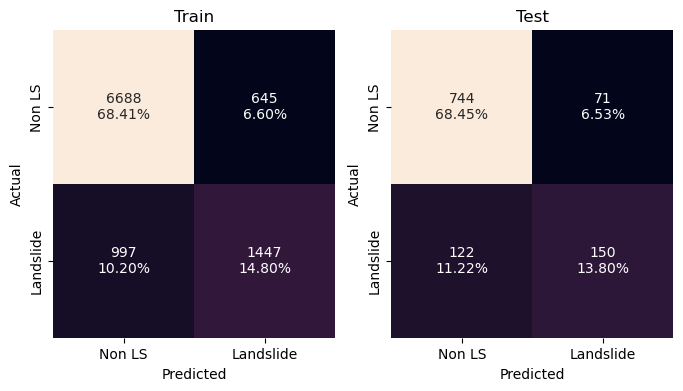

******************************************************************************************


In [32]:
# on engineered data, without class weights
ADA_base = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1, random_state=1), n_estimators=50, learning_rate=1.0, random_state = 14)
tree_model_perf(ADA_base, 'ADA_base', X_train_eng, X_test_eng, y_train_eng, y_test_eng)

ADA_weights:  AUC = 0.873, Time: 0.79
Train
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      7333
           1       0.54      0.82      0.65      2444

    accuracy                           0.78      9777
   macro avg       0.74      0.80      0.75      9777
weighted avg       0.83      0.78      0.79      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       815
           1       0.54      0.83      0.66       272

    accuracy                           0.78      1087
   macro avg       0.74      0.80      0.75      1087
weighted avg       0.83      0.78      0.79      1087



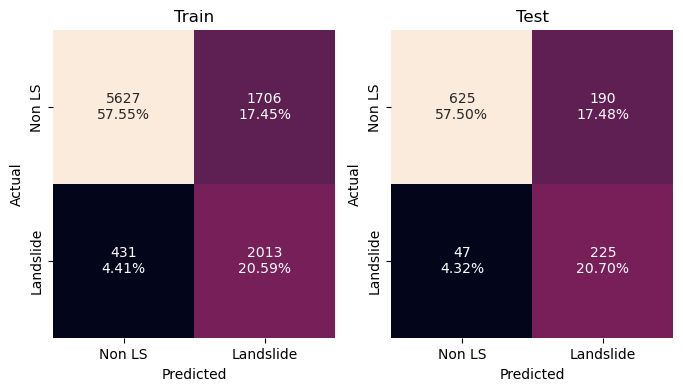

******************************************************************************************


In [33]:
# class weights
ADA_weights = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1, random_state=1, class_weight=class_weights),
                              n_estimators=50, learning_rate=1.0, random_state = 14)
tree_model_perf(ADA_weights, 'ADA_weights', X_train_eng, X_test_eng, y_train_eng, y_test_eng)

## Original data

In [34]:
X_og = df_og
Y = df.Label

X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, Y, stratify=Y, test_size=0.1, random_state=14)

ADA_og:  AUC = 0.878, Time: 8.04
Train
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      7333
           1       0.56      0.82      0.66      2444

    accuracy                           0.79      9777
   macro avg       0.74      0.80      0.76      9777
weighted avg       0.84      0.79      0.80      9777

Test
              precision    recall  f1-score   support

           0       0.92      0.80      0.85       815
           1       0.57      0.79      0.66       272

    accuracy                           0.80      1087
   macro avg       0.74      0.80      0.76      1087
weighted avg       0.83      0.80      0.81      1087



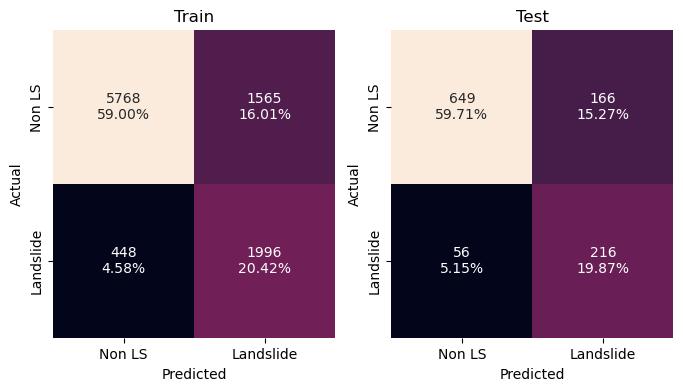

******************************************************************************************


In [35]:
# original data
ADA_og = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1, random_state=1, class_weight=class_weights), n_estimators=50, learning_rate=1.0, random_state = 14)
tree_model_perf(ADA_og, 'ADA_og', X_train_og, X_test_og, y_train_og, y_test_og)

## Combined data

In [36]:
X_combined = df_combined.drop(columns='Label')
Y = df_combined.Label

X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, Y, stratify=Y, test_size=0.1, random_state=14)

ADA_combined:  AUC = 0.883, Time: 8.53
Train
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      7333
           1       0.58      0.83      0.68      2444

    accuracy                           0.81      9777
   macro avg       0.76      0.81      0.77      9777
weighted avg       0.84      0.81      0.82      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       815
           1       0.58      0.81      0.68       272

    accuracy                           0.80      1087
   macro avg       0.75      0.81      0.77      1087
weighted avg       0.84      0.80      0.81      1087



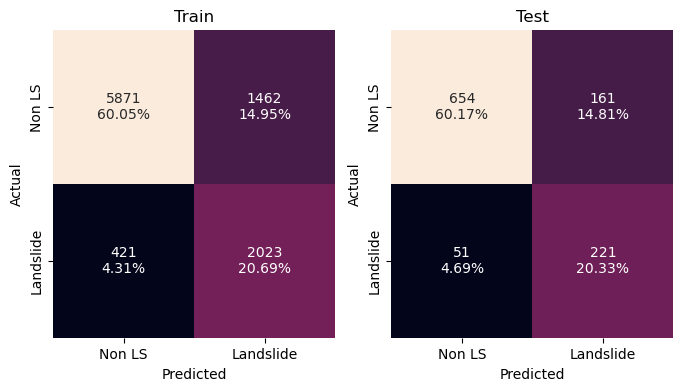

******************************************************************************************


In [37]:
# combined data
ADA_combined = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1, class_weight=class_weights), 
                                  n_estimators=50, learning_rate=1.0, random_state = 14)
tree_model_perf(ADA_combined, 'ADA_combined', X_train_combined, X_test_combined, y_train_combined, y_test_combined)

## Comparing AUC

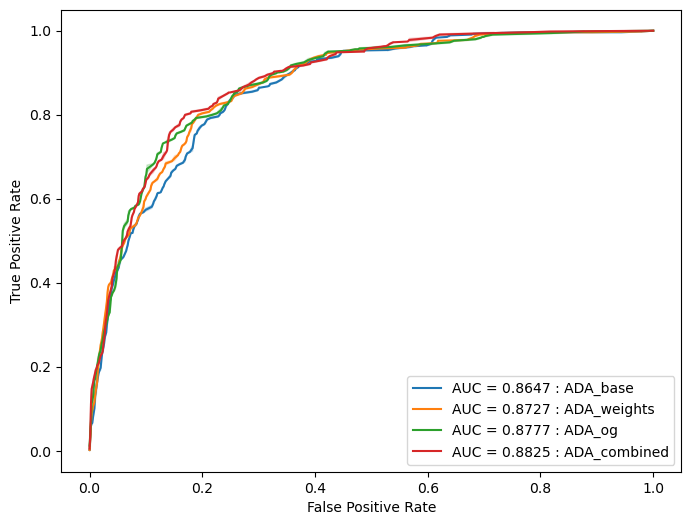

In [39]:
plt.figure(figsize=(8,6))

for model, model_name, X_test, y_test in [
    (ADA_base, 'ADA_base', X_test_eng, y_test_eng),
    (ADA_weights, 'ADA_weights', X_test_eng, y_test_eng),
    (ADA_og, 'ADA_og', X_test_og, y_test_og),
    (ADA_combined, 'ADA_combined', X_test_combined, y_test_combined)
]:
    yhat_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  yhat_proba)
    auc_score = metrics.roc_auc_score(y_test,  yhat_proba)
    space = ' ' * (20 - len(model_name))
    sns.lineplot(x=fpr,y=tpr, label=f'AUC = {auc_score:0.4f} : {model_name}')
    
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()    

## Kfold cross validation

In [44]:
ADA_weights_CV = cross_validate(ADA_weights, X_eng, Y, cv=10, scoring='roc_auc')
pd.DataFrame(ADA_weights_CV).mean()

fit_time     0.6855
score_time   0.0134
test_score   0.8646
dtype: float64

In [45]:
ADA_og_CV = cross_validate(ADA_og, X_og, Y, cv=10, scoring='roc_auc')
pd.DataFrame(ADA_og_CV).mean()

fit_time     7.5945
score_time   0.0308
test_score   0.8650
dtype: float64

In [46]:
ADA_combined_CV = cross_validate(ADA_combined, X_combined, Y, cv=10, scoring='roc_auc')
pd.DataFrame(ADA_combined_CV).mean()

fit_time     8.1670
score_time   0.0433
test_score   0.8727
dtype: float64

While having more features resulted in slightly better predictions, the training time increased by 10-12 times as well.

## Hyper parameter tuning

### 1

In [52]:
%%time
param_grid = {
    'n_estimators': [30, 50, 75, 100],
    'learning_rate': [0.1, 0.5, 1.0],
}

ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1, class_weight=class_weights), random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(ada, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train_combined, y_train_combined)

grid_search.best_params_

CPU times: total: 12.3 s
Wall time: 1min 27s


{'learning_rate': 0.5, 'n_estimators': 75}

ADA_tuned1:  AUC = 0.886, Time: 12.69
Train
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7333
           1       0.57      0.84      0.68      2444

    accuracy                           0.80      9777
   macro avg       0.75      0.81      0.77      9777
weighted avg       0.84      0.80      0.81      9777

Test
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       815
           1       0.56      0.81      0.66       272

    accuracy                           0.79      1087
   macro avg       0.74      0.80      0.76      1087
weighted avg       0.83      0.79      0.81      1087



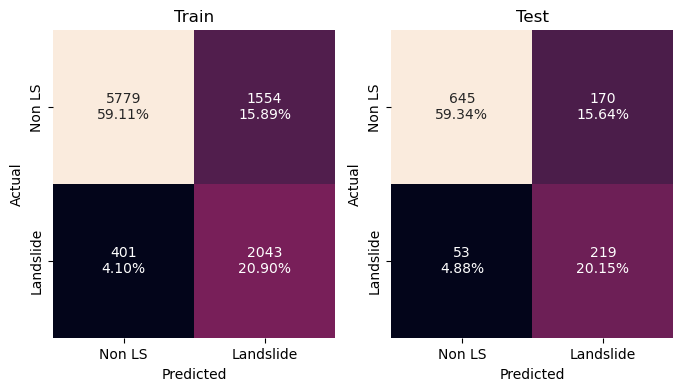

******************************************************************************************


In [54]:
ADA_tuned1 = grid_search.best_estimator_
tree_model_perf(ADA_tuned1, 'ADA_tuned1', X_train_combined, X_test_combined, y_train_combined, y_test_combined)

In [55]:
# cross validation
ADA_tuned1_CV = cross_validate(ADA_tuned1, X_combined, Y, cv=10, scoring='roc_auc')
pd.DataFrame(ADA_tuned1_CV).mean()

fit_time     12.2351
score_time    0.0644
test_score    0.8778
dtype: float64

Hyperparameter tuning increased adaboost performance.

### 2

In [57]:
%%time
param_grid = {
    'n_estimators': [70, 75, 80],
    'learning_rate': [0.4, 0.5, 0.6],
}

ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1, class_weight=class_weights), random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(ada, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train_combined, y_train_combined)

grid_search.best_params_

CPU times: total: 13 s
Wall time: 1min 14s


{'learning_rate': 0.5, 'n_estimators': 80}

ADA_tuned2:  AUC = 0.885, Time: 13.84
Train
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7333
           1       0.57      0.84      0.68      2444

    accuracy                           0.80      9777
   macro avg       0.75      0.81      0.77      9777
weighted avg       0.84      0.80      0.81      9777

Test
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       815
           1       0.56      0.80      0.66       272

    accuracy                           0.79      1087
   macro avg       0.74      0.79      0.76      1087
weighted avg       0.83      0.79      0.80      1087



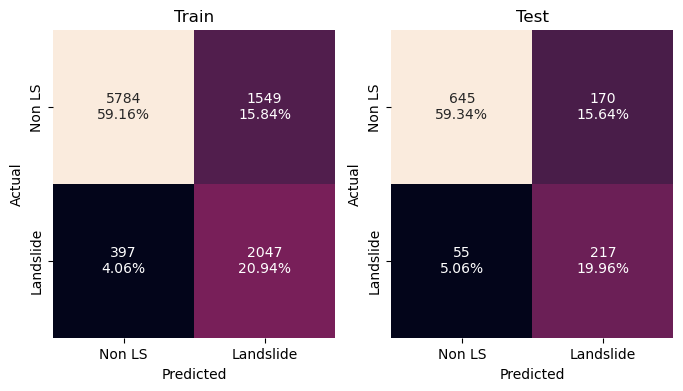

******************************************************************************************


In [58]:
ADA_tuned2 = grid_search.best_estimator_
tree_model_perf(ADA_tuned2, 'ADA_tuned2', X_train_combined, X_test_combined, y_train_combined, y_test_combined)

In [59]:
# cross validation
ADA_tuned2_CV = cross_validate(ADA_tuned2, X_combined, Y, cv=10, scoring='roc_auc')
pd.DataFrame(ADA_tuned2_CV).mean()

fit_time     13.1647
score_time    0.0699
test_score    0.8781
dtype: float64

Seems like we arrived at an optimal parameters for adaboost

# 3. Conclusion

- Adaboost doesn't suffered from the curse of dimensionality, in fact it performed better with more features.